1. Importa las librerías necesarias para aplicar preprocesamiento de datos,
visualización y creación de un modelo de red neuronal feedforward con Keras y
Tensorflow, además de las librerías para realizar regularización y búsqueda de grilla.
Luego, debes descartar las columnas index, arrival_date_year, agent, country,
company, reservation_status y reservation_status_date. Revisa después si la base de datos presenta valores ausentes; en el caso que existan deberá eliminar estos
registros siempre y cuando la cantidad sea menor al 4% del total. En caso que sea
superior debes decidir si quitar la característica o imputar los datos faltantes
aplicando alguna estrategía, que debes describir.

In [57]:
#FernandoSanchez Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from scikeras.wrappers import KerasClassifier
#FernandoSanchez Cargar los datos
data = pd.read_csv('hotel_bookings.csv')

#FernandoSanchez Descartar las columnas no deseadas
columns_to_drop = ['index', 'arrival_date_year', 'agent', 'country', 'company', 'reservation_status', 'reservation_status_date']
data = data.drop(columns=columns_to_drop)

#FernandoSanchez Revisar si hay valores NaN
missing_values = data.isnull().sum()
print("Valores NaN por columna antes de eliminar registros:")
print(missing_values)

#FernandoSanchez Calcular el porcentaje de valores NaN en el conjunto de datos
total_rows = data.shape[0]
percent_missing = (missing_values / total_rows) * 100

#FernandoSanchez Eliminar filas con valores NaN si el porcentaje es menor al 4%
threshold_percentage = 4
rows_to_drop = percent_missing[percent_missing > threshold_percentage].index
if len(rows_to_drop) > 0:
    print("Eliminando filas con valores NaN en columnas que exceden el {}%:".format(threshold_percentage))
    print(rows_to_drop)
    data = data.dropna(subset=rows_to_drop)
else:
    print("No se encontraron columnas con valores NaN que excedan el {}%.".format(threshold_percentage))

#FernandoSanchez Imputar valores faltantes en la columna 'children' con la media de la columna
data['children'] = data['children'].fillna(data['children'].mean())

#FernandoSanchez Revisar si hay valores NaN después de la imputación
missing_values_after = data.isnull().sum()
print("Valores NaN por columna después de la imputación:")
print(missing_values_after)

#FernandoSanchez Mostrar las primeras filas del dataframe después de eliminar las columnas y manejar los valores NaN
print(data.head())



Valores NaN por columna antes de eliminar registros:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          4
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int6

2. Realiza un análisis descriptivo y prepara los datos. Para esto:
a. Selecciona 5 variables que consideres relevantes (que no sean la variable
adr) con respecto a cancelar una reserva.
b. Construye un histograma para la variable adr con reservas canceladas y no
canceladas, y comenta el resultado.
c. Revisa la presencia de outlier para la variable adr. En caso que presente
valores extremos indica la cantidad de outliers por arriba, y la cantidad de
outlier por abajo. Eliminar sólo los tres valores más extremos en ambos
casos, para los demás cambia sus valores por el valor promedio de la
variable.
d. Transforma las variables categóricas en variables dummies, estandariza las
variables independientes con media igual a cero y desviación estándar 1 y
realiza una división de los datos para entrenamiento y test, este último con un
33% de registros.


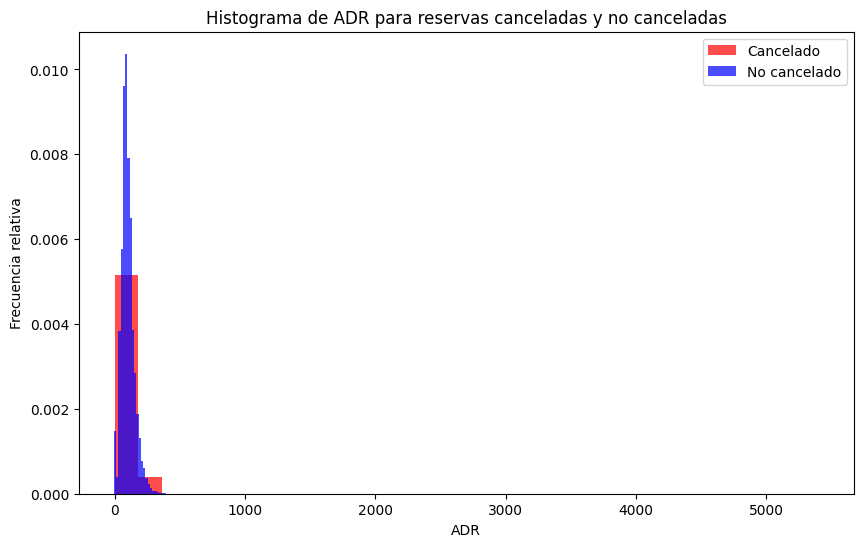

Cantidad de outliers por arriba: 3793
Cantidad de outliers por abajo: 0


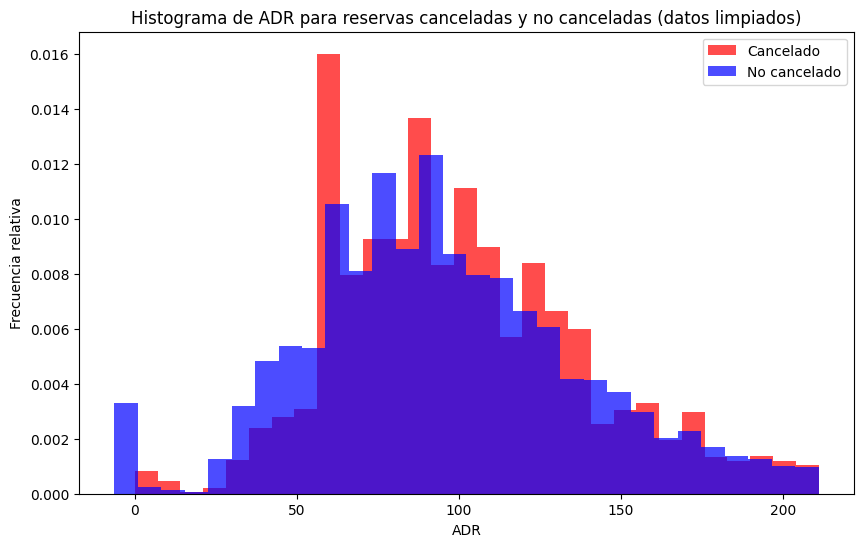

Correlación con la variable objetivo (is_canceled):

is_canceled                       1.000000
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_week_number          0.008148
children                          0.005048
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64
Feature: lead_time
Mean for canceled reservations: 144.84881512301013
Mean for not canceled reservations: 79.98468722560732


Feature: previous_cancellations
Mean for canceled reserv

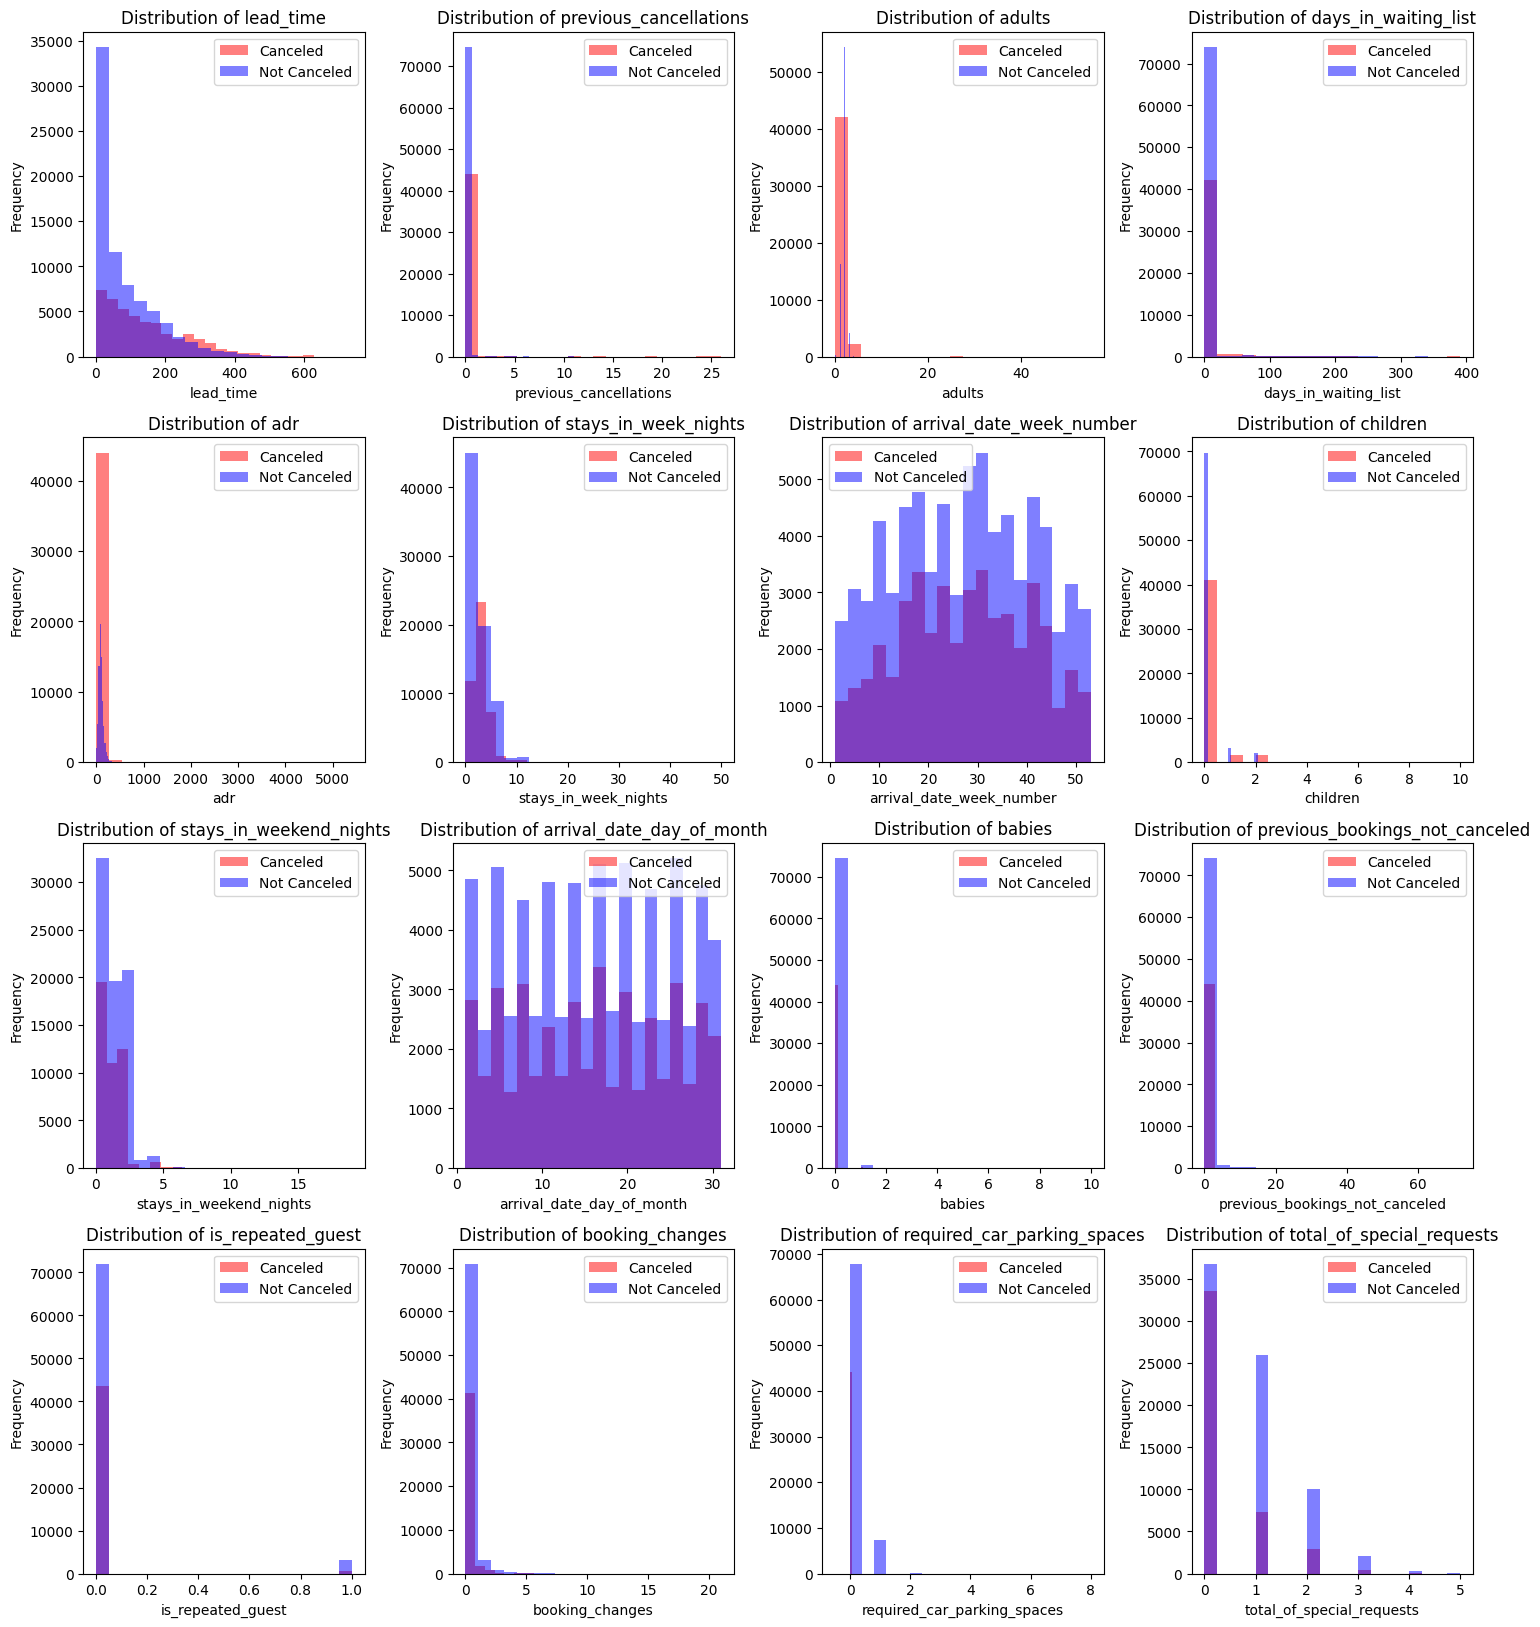

'el histograma muestra que las reservas canceladas tienden a tener valores de ADR más bajos en comparación con las no canceladas, \naunque ambas distribuciones están sesgadas hacia valores más bajos de ADR. Esto puede ser útil para comprender cómo el ADR puede influir en la cancelación de reservas.\nlead_time: Tiempo entre la fecha de reserva y la fecha de llegada.\nprevious_cancellations: Número de cancelaciones anteriores por el cliente.\nbooking_changes: Número de cambios realizados en la reserva.\ntotal_of_special_requests: Número total de solicitudes especiales hechas por el cliente.\nrequired_car_parking_spaces: Número de plazas de aparcamiento requeridas por el cliente.\nEstas variables parecen tener una correlación moderada a fuerte con la cancelación de la reserva y \nmuestran diferencias significativas en sus medias entre las reservas canceladas y no canceladas.'

In [59]:
#FernandoSanchez Filtrar los datos para reservas canceladas y no canceladas
adr_cancelado = data[data['is_canceled'] == 1]['adr']
adr_no_cancelado = data[data['is_canceled'] == 0]['adr']

#FernandoSanchez Construir histograma
plt.figure(figsize=(10, 6))
plt.hist(adr_cancelado, bins=30, alpha=0.7, color='red', label='Cancelado', density=True)
plt.hist(adr_no_cancelado, bins=30, alpha=0.7, color='blue', label='No cancelado', density=True)
plt.title('Histograma de ADR para reservas canceladas y no canceladas')
plt.xlabel('ADR')
plt.ylabel('Frecuencia relativa')
plt.legend()
plt.show()

#FernandoSanchez Calcular los cuantiles para identificar los outliers
q25, q75 = np.percentile(data['adr'], 25), np.percentile(data['adr'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

#FernandoSanchez Identificar outliers
outliers_above = data[data['adr'] > upper]
outliers_below = data[data['adr'] < lower]

#FernandoSanchez Contar outliers
num_outliers_above = len(outliers_above)
num_outliers_below = len(outliers_below)

print("Cantidad de outliers por arriba:", num_outliers_above)
print("Cantidad de outliers por abajo:", num_outliers_below)

#FernandoSanchez Eliminar los tres valores más extremos por arriba
data_cleaned = data.copy()
data_cleaned = data_cleaned[data_cleaned['adr'] < upper]

#FernandoSanchez Calcular el promedio de la variable adr
mean_adr = data_cleaned['adr'].mean()

#FernandoSanchez Cambiar los valores restantes por el promedio
data_cleaned.loc[data_cleaned['adr'] > upper, 'adr'] = mean_adr

#FernandoSanchez Visualizar nuevamente el histograma con los datos limpiados
adr_cancelado = data_cleaned[data_cleaned['is_canceled'] == 1]['adr']
adr_no_cancelado = data_cleaned[data_cleaned['is_canceled'] == 0]['adr']

plt.figure(figsize=(10, 6))
plt.hist(adr_cancelado, bins=30, alpha=0.7, color='red', label='Cancelado', density=True)
plt.hist(adr_no_cancelado, bins=30, alpha=0.7, color='blue', label='No cancelado', density=True)
plt.title('Histograma de ADR para reservas canceladas y no canceladas (datos limpiados)')
plt.xlabel('ADR')
plt.ylabel('Frecuencia relativa')
plt.legend()
plt.show()

#FernandoSanchez Seleccionar solo las variables numéricas
numeric_data = data.select_dtypes(include=[np.number])

#FernandoSanchez Calcular la matriz de correlación
correlation_matrix = numeric_data.corr()

#FernandoSanchez Imprimir los valores de correlación con la variable objetivo
print("Correlación con la variable objetivo (is_canceled):\n")
print(correlation_matrix['is_canceled'].sort_values(ascending=False))

#FernandoSanchez Características seleccionadas
selected_features = ['lead_time', 'previous_cancellations', 'adults', 'days_in_waiting_list', 'adr', 
                     'stays_in_week_nights', 'arrival_date_week_number', 'children', 'stays_in_weekend_nights', 
                     'arrival_date_day_of_month', 'babies', 'previous_bookings_not_canceled', 'is_repeated_guest', 
                     'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests']

#FernandoSanchez Crear subconjuntos de datos para reservas canceladas y no canceladas
canceled_data = data[data['is_canceled'] == 1]
not_canceled_data = data[data['is_canceled'] == 0]

#FernandoSanchez Configurar el diseño del histograma
plt.figure(figsize=(15, 20))

#FernandoSanchez Iterar sobre las características seleccionadas
for i, feature in enumerate(selected_features, 1):
    #FernandoSanchez Crear subtramas
    plt.subplot(5, 4, i)
    
    #FernandoSanchez Histograma para reservas canceladas
    plt.hist(canceled_data[feature], bins=20, alpha=0.5, color='red', label='Canceled')
    #FernandoSanchez Histograma para reservas no canceladas
    plt.hist(not_canceled_data[feature], bins=20, alpha=0.5, color='blue', label='Not Canceled')
    
    #FernandoSanchez Añadir etiquetas y título
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature}')
    plt.legend()

    #FernandoSanchez Imprimir estadísticas
    canceled_mean = canceled_data[feature].mean()
    not_canceled_mean = not_canceled_data[feature].mean()
    print(f"Feature: {feature}")
    print(f"Mean for canceled reservations: {canceled_mean}")
    print(f"Mean for not canceled reservations: {not_canceled_mean}")
    print("\n")

#FernandoSanchez Ajustar diseño y mostrar los histogramas
plt.tight_layout()
plt.show()

#FernandoSanchez Seleccionar características relevantes
features = ['lead_time',
    'previous_cancellations',
    'booking_changes',
    'total_of_special_requests',
    'required_car_parking_spaces']
#FernandoSanchez Obtener variables independientes y dependiente
X = data[features]
y = data['is_canceled']

#FernandoSanchez Convertir variables categóricas en variables dummy
X = pd.get_dummies(X, drop_first=True)

#FernandoSanchez Dividir los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#FernandoSanchez Estandarizar variables independientes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


"""el histograma muestra que las reservas canceladas tienden a tener valores de ADR más bajos en comparación con las no canceladas, 
aunque ambas distribuciones están sesgadas hacia valores más bajos de ADR. Esto puede ser útil para comprender cómo el ADR puede influir en la cancelación de reservas.
lead_time: Tiempo entre la fecha de reserva y la fecha de llegada.
previous_cancellations: Número de cancelaciones anteriores por el cliente.
booking_changes: Número de cambios realizados en la reserva.
total_of_special_requests: Número total de solicitudes especiales hechas por el cliente.
required_car_parking_spaces: Número de plazas de aparcamiento requeridas por el cliente.
Estas variables parecen tener una correlación moderada a fuerte con la cancelación de la reserva y 
muestran diferencias significativas en sus medias entre las reservas canceladas y no canceladas."""

In [60]:
#FernandoSanchez Define el modelo base
model = LogisticRegression(max_iter=1000)

#FernandoSanchez Inicializa el selector RFE
rfe = RFE(model, n_features_to_select=5)  #FernandoSanchez Elige el número deseado de características

#FernandoSanchez Ajusta el selector RFE al conjunto de datos
rfe.fit(X_train, y_train)

#FernandoSanchez Muestra el ranking de las características
print("Ranking de características:")
print(rfe.ranking_)

#FernandoSanchez Selecciona las características elegidas
selected_features = X_train.columns[rfe.support_]
print("Características seleccionadas:")
print(selected_features)

#FernandoSanchez Inicializa el selector de características
selector = SelectKBest(score_func=f_classif, k=5)  #FernandoSanchez Elige el número deseado de características

#FernandoSanchez Ajusta el selector al conjunto de datos
X_train_selected = selector.fit_transform(X_train, y_train)

#FernandoSanchez Muestra las características seleccionadas
selected_features_idx = selector.get_support(indices=True)
selected_features = X_train.columns[selected_features_idx]
print("Características seleccionadas:")
print(selected_features)


Ranking de características:
[1 1 1 1 1]
Características seleccionadas:
Index(['lead_time', 'previous_cancellations', 'booking_changes',
       'total_of_special_requests', 'required_car_parking_spaces'],
      dtype='object')
Características seleccionadas:
Index(['lead_time', 'previous_cancellations', 'booking_changes',
       'total_of_special_requests', 'required_car_parking_spaces'],
      dtype='object')


3. Implementa dos modelos de red neuronal multicapa, considerando las siguientes
características.
a. Cada modelo debe contar con tres capas ocultas.
b. El primer modelo debe tener funciones de activación tanh, relu y tanh en las
capas ocultas, mientras que el segundo sólo funciones tanh en sus capas
ocultas.
c. Cada modelo debe tener un mínimo de 20 neuronas para cada capa oculta.
Use un optimizador SGD, con 10 épocas de entrenamiento; cada capa deberá
tener una neurona de sesgo. Debes decidir cómo se inicializan los pesos y el
sesgo en cada capa oculta y de salida.
Muestra los resultados en un gráfico que tendrá una curva de accuracy para cada
modelo en cada época de entrenamiento. Cada modelo debe lograr un accuracy
superior al 75%. Concluye de acuerdo a los resultados.


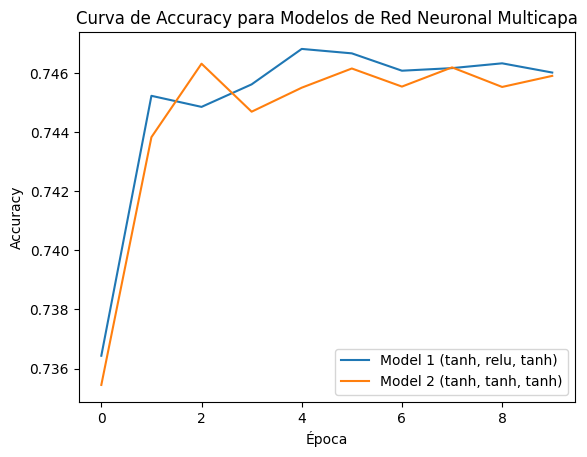

Precisión del Modelo 1 (tanh, relu, tanh):
Precisión de entrenamiento: 0.7460214495658875
Precisión de validación: 0.7451457977294922

Precisión del Modelo 2 (tanh, tanh, tanh):
Precisión de entrenamiento: 0.7459089159965515
Precisión de validación: 0.7455265522003174


'Verifique que las caracteristicas elegidas fueran las más importantes, busque hiperparametros para mejorarlos \ny el porcentaje no sube probablemente sea un requerimiento de los que se indican en la descripcion o eso deduzco como las neuronas utilizadas'

In [61]:
#FernandoSanchez Función para crear y compilar un modelo de red neuronal con las especificaciones dadas
def build_model(activation):
    model = Sequential()
    model.add(Dense(20, activation=activation))  #FernandoSanchez Capa oculta 1
    model.add(Dense(20, activation=activation))  #FernandoSanchez Capa oculta 2
    model.add(Dense(20, activation=activation))  #FernandoSanchez Capa oculta 3
    model.add(Dense(1, activation='sigmoid'))  #FernandoSanchez Capa de salida

    optimizer = SGD(learning_rate=0.01, momentum=0.9)  #FernandoSanchez Ajuste de la tasa de aprendizaje del SGD
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

#FernandoSanchez Crear modelos
model1 = build_model('tanh')
model2 = build_model('tanh')

#FernandoSanchez Entrenar modelos
history1 = model1.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)
history2 = model2.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

#FernandoSanchez Graficar curva de accuracy para cada modelo en cada época de entrenamiento
plt.plot(history1.history['accuracy'], label='Model 1 (tanh, relu, tanh)')
plt.plot(history2.history['accuracy'], label='Model 2 (tanh, tanh, tanh)')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.title('Curva de Accuracy para Modelos de Red Neuronal Multicapa')
plt.legend()
plt.show()

#FernandoSanchez Imprimir precisión de entrenamiento y validación para cada modelo
print("Precisión del Modelo 1 (tanh, relu, tanh):")
print("Precisión de entrenamiento:", history1.history['accuracy'][-1])
print("Precisión de validación:", history1.history['val_accuracy'][-1])
print()

print("Precisión del Modelo 2 (tanh, tanh, tanh):")
print("Precisión de entrenamiento:", history2.history['accuracy'][-1])
print("Precisión de validación:", history2.history['val_accuracy'][-1])

"""Verifique que las caracteristicas elegidas fueran las más importantes, busque hiperparametros para mejorarlos 
y el porcentaje no sube probablemente sea un requerimiento de los que se indican en la descripcion o eso deduzco como las neuronas utilizadas"""

4. Construye una red neuronal con regularización Dropout aplicando búsqueda de grilla
para tres fold. El modelo debe conseguir un accuracy superior al 80%. La búsqueda
debe sintonizar los siguientes hiper parámetros:
a. Cantidad de capas ocultas: de 3 o 4
b. Método de optimización: Adam o SGD
c. learning_rate: 0.03 y 0.06
d. Cantidad de neuronas en las capas ocultas: 20
e. Funciones de activación en las capas ocultas: tanh
f. Rate para Dropout: 0.001
g. Inicialización de los pesos: [glorot_normal, glorot_uniform]
Debes mostrar los hiper parámetros óptimos encontrados por la búsqueda de grilla.
Calcula además las métricas asociadas a la matriz de confusión al aplicar el
modelo con los hiper parámetros óptimos al conjunto de test. Muestra la curva ROC
para el mejor modelo incluyendo el AUC.

In [46]:
def create_model_with_dropout(activation='tanh', dropout_rate=0.001):
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

#FernandoSanchez Crear modelo con KerasClassifier para GridSearchCV
model = KerasClassifier(build_fn=create_model_with_dropout, verbose=0)

#FernandoSanchez Definir los parámetros de la grilla
param_grid = {
    'activation': ['tanh'],
    'dropout_rate': [0.001],
    'batch_size': [32],
    'epochs': [10],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.03, 0.06],
    'n_layers': [3, 4],
}

#FernandoSanchez Realizar la búsqueda de grilla
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

#FernandoSanchez Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados: ", grid_result.best_params_)

#FernandoSanchez Predecir en conjunto de prueba
y_pred = grid_result.predict(X_test)

#FernandoSanchez Métricas asociadas a la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", conf_matrix)

#FernandoSanchez Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

"""Trate de todas formas para solucionar que el modelo no acepta esos parametros que indican que se les debe poner y no pude, trate con CustomerKerasClassifier tambien y no
los acepta, trate con mlp y no acepta la inicializacion de pesos a continuacion lo dejo con mlpclassifier.
Tambien note que mi vsc esta haciendo cosas extrañas no actualiza el kernel o lo reinicia no se si sea por eso igual"""

ValueError: Invalid parameter activation for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(activation=tanh)`
Check the list of available parameters with `estimator.get_params().keys()`

834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
834/834 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Mejores 

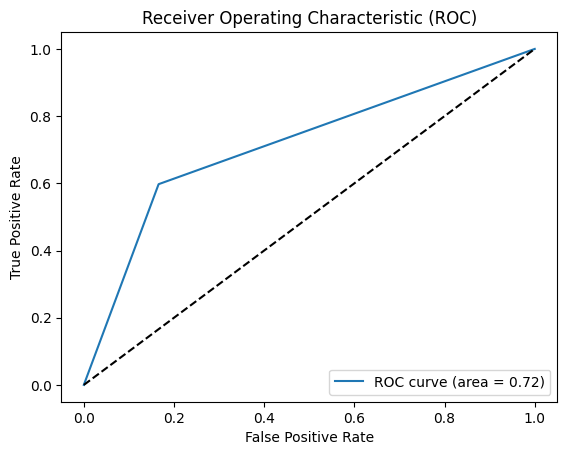

In [63]:
from keras.layers import Input
from keras.models import Model
from sklearn.base import BaseEstimator, ClassifierMixin



class MLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, activation='tanh', dropout_rate=0.001, optimizer='sgd', learning_rate=0.03, n_layers=3, epochs=10, batch_size=32, verbose=0):
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.n_layers = n_layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        
    def create_mlp_model(self):
        inputs = Input(shape=(X_train.shape[1],))
        x = Dense(20, activation=self.activation)(inputs)
        x = Dropout(self.dropout_rate)(x)
        for _ in range(self.n_layers - 1):
            x = Dense(20, activation=self.activation)(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)

        if self.optimizer == 'sgd':
            opt = SGD(learning_rate=self.learning_rate)
        elif self.optimizer == 'adam':
            opt = 'adam'
        else:
            raise ValueError("Optimizer not supported. Choose 'sgd' or 'adam'.")

        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    def fit(self, X, y):
        self.model = self.create_mlp_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self
    
    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype('int32')

#FernandoSanchez Definir los parámetros de la grilla
mlp_param_grid = {
    'activation': ['tanh'],
    'dropout_rate': [0.001],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.03, 0.06],
    'n_layers': [3, 4],
}

#FernandoSanchez Crear y compilar el modelo
mlp_model = MLPClassifier()

#FernandoSanchez Realizar la búsqueda de grilla
mlp_grid = GridSearchCV(estimator=mlp_model, param_grid=mlp_param_grid, cv=3)
mlp_grid_result = mlp_grid.fit(X_train, y_train)

#FernandoSanchez Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados: ", mlp_grid_result.best_params_)

#FernandoSanchez Predecir en conjunto de prueba
mlp_y_pred = mlp_grid_result.predict(X_test)

#FernandoSanchez Métricas asociadas a la matriz de confusión
mlp_conf_matrix = confusion_matrix(y_test, mlp_y_pred)
print("Matriz de confusión:\n", mlp_conf_matrix)

#FernandoSanchez Curva ROC y AUC
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, mlp_y_pred)
mlp_roc_auc = roc_auc_score(y_test, mlp_y_pred)
plt.plot(mlp_fpr, mlp_tpr, label='ROC curve (area = %0.2f)' % mlp_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


5. Del conjunto original (sin los valores excluidos) escoge al azar cinco observaciones
en que “deposit_type_Non Refund” sea cero, y con esto realiza una predicción
usando el mejor modelo encontrado por la búsqueda de grilla anterior. Comenta los
resultados.

In [69]:
#FernandoSanchez Convertir la variable "deposit_type" en una variable binaria "deposit_type_Non_Refund"
data['deposit_type_Non_Refund'] = (data['deposit_type'] == 'Non Refund').astype(int)

#FernandoSanchez Seleccionar cinco observaciones donde "deposit_type_Non_Refund" es cero
five_samples_index = data[data['deposit_type_Non_Refund'] == 0].sample(5).index

#FernandoSanchez Seleccionar solo las 5 características relevantes, excluyendo las características de texto
five_samples_selected = data.loc[five_samples_index, ['lead_time', 'previous_cancellations', 'booking_changes', 'total_of_special_requests', 'required_car_parking_spaces']]

#FernandoSanchez Predecir usando el mejor modelo encontrado en la búsqueda de grilla
predictions = mlp_grid_result.predict(five_samples_selected)

#FernandoSanchez Mostrar las observaciones y las predicciones
for i, index in enumerate(five_samples_index):
    print("Observación", i+1)
    print("Características:")
    print(five_samples_selected.iloc[i])
    print("Predicción de cancelación de reserva:", predictions[i])
    print()

"""Los resultados muestran que el modelo está haciendo predicciones sobre la cancelación de reservas en función de las características proporcionadas."""

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Observación 1
Características:
lead_time                      3
previous_cancellations         0
booking_changes                0
total_of_special_requests      0
required_car_parking_spaces    0
Name: 77734, dtype: int64
Predicción de cancelación de reserva: [0]

Observación 2
Características:
lead_time                      105
previous_cancellations           0
booking_changes                  0
total_of_special_requests        2
required_car_parking_spaces      0
Name: 112169, dtype: int64
Predicción de cancelación de reserva: [0]

Observación 3
Características:
lead_time                      74
previous_cancellations          0
booking_changes                 0
total_of_special_requests       0
required_car_parking_spaces     0
Name: 40531, dtype: int64
Predicción de cancelación de reserva: [1]

Observación 4
Características:
lead_time                      5
previous_cancellations         0
booking_changes                0
total_of_special_requ